In [15]:
import json
import pandas as pd
from XGB_model import train_multiple_model
import seaborn as sns
from data_processing_tools import *
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import missingno as msno

# Loading data
data_raw = []
with open('transactions.txt') as f:
    for line in f.readlines():
        data_raw.append(json.loads(line))
data = pd.DataFrame(data_raw)
print('... Data import completed, with {} observations and {} features ...'.format(data.shape[0], data.shape[1]))
del data_raw

... Data import completed, with 786363 observations and 29 features ...


In [16]:
data = data.applymap(lambda x: None if x == '' else x)
# identifying unique values
data.apply(lambda x: len(x.unique()), axis=1)
# there are in all 10 levels of credit limit, 19 types of merchants.

0         16
1         17
2         16
3         16
4         17
          ..
786358    18
786359    18
786360    18
786361    18
786362    18
Length: 786363, dtype: int64

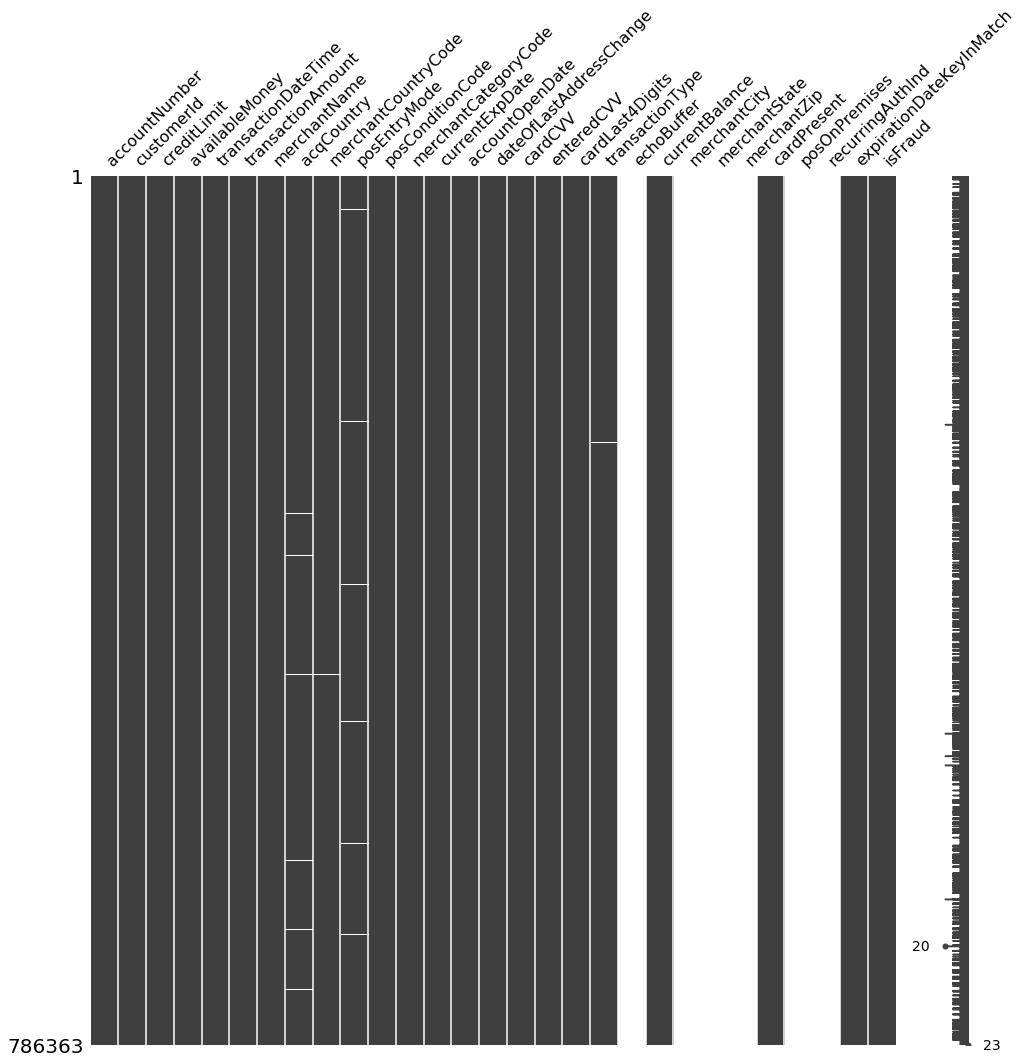

In [17]:
# Missing Value Visualization
msno.matrix(data.sample(data.shape[0]), figsize=(16, 16), width_ratios=(15, 1))

In [18]:
# Counting the missing values
data.isnull().sum()

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

From the above figure and calculations, we concluded that features 'merchantCity', 'merchantState', 'merchantZip',
'posOnPremises' and 'recurringAuthId' are all empty values; features 'acqCountry', 'merchantCountryCode', 'posEntryMode'
, 'posConditionCode' and 'transactionType' have a few missing values; the rest of the features have no null values.

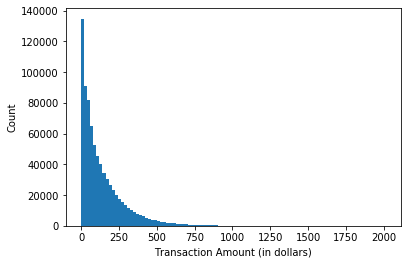

In [3]:
# histogram plotting
plt.hist(data['transactionAmount'], bins=100)
plt.xlabel('Transaction Amount (in dollars)')
plt.ylabel('Count')
plt.show()


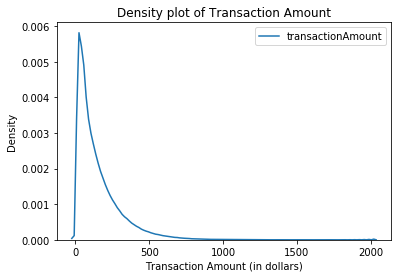

In [5]:
sns.kdeplot(data['transactionAmount'])
plt.xlabel('Transaction Amount (in dollars)')
plt.ylabel('Density')
plt.title('Density plot of Transaction Amount')
plt.show()
# The distribution of feature Transaction Amount is highly positive skewed. We presume a Chi-square distribution on this
# feature.


In [6]:
# converting bool to discrete 0/1 variable
bool_columns = ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']
for c in bool_columns:
    data[c] = data[c].apply(lambda x: 1 if x else 0)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 35 columns):
accountNumber               786363 non-null object
customerId                  786363 non-null object
creditLimit                 786363 non-null float64
availableMoney              786363 non-null float64
transactionDateTime         786363 non-null datetime64[ns]
transactionAmount           786363 non-null float64
merchantName                786363 non-null object
acqCountry                  781801 non-null object
merchantCountryCode         785639 non-null object
posEntryMode                782309 non-null object
posConditionCode            785954 non-null object
merchantCategoryCode        786363 non-null object
currentExpDate              786363 non-null datetime64[ns]
accountOpenDate             786363 non-null datetime64[ns]
dateOfLastAddressChange     786363 non-null datetime64[ns]
cardCVV                     786363 non-null object
enteredCVV                  786363 non

In [10]:
data.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_year,transaction_month,transaction_day,transaction_hour,transaction_minute,transaction_second
count,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.0,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089,0.448734,0.001326,0.015790,2016.0,6.648343,15.732804,11.511333,29.518682,29.510929
std,11636.174890,8880.783989,147.725569,6457.442068,0.497365,0.036395,0.124664,0.0,3.436256,8.780564,6.921098,17.325778,17.315639
min,250.000000,-1005.630000,0.000000,0.000000,0.000000,0.000000,0.000000,2016.0,1.000000,1.000000,0.000000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000,0.000000,0.000000,0.000000,2016.0,4.000000,8.000000,6.000000,15.000000,15.000000
50%,7500.000000,3184.860000,87.900000,2451.760000,0.000000,0.000000,0.000000,2016.0,7.000000,16.000000,12.000000,30.000000,30.000000
75%,15000.000000,7500.000000,191.480000,5291.095000,1.000000,0.000000,0.000000,2016.0,10.000000,23.000000,18.000000,45.000000,45.000000
max,50000.000000,50000.000000,2011.540000,47498.810000,1.000000,1.000000,1.000000,2016.0,12.000000,31.000000,23.000000,59.000000,59.000000


In [ ]:
# converting bool to discrete 0/1 variable
bool_columns = ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']
for c in bool_columns:
    data[c] = data[c].apply(lambda x: 1 if x else 0)

# converting Date-time into year-month-day-hour-minute-second
data['transactionDateTime'] = \
    data['transactionDateTime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

for i in ['year', 'month', 'day', 'hour', 'minute', 'second']:
    data['transaction_' + i] = data['transactionDateTime'].apply(lambda x: float(x.__getattribute__(i)))

data['accountOpenDate'] = data['accountOpenDate'].apply(date_transfer)
data['dateOfLastAddressChange'] = data['dateOfLastAddressChange'].apply(date_transfer)
data['currentExpDate'] = data['currentExpDate'].apply(lambda x: datetime.datetime.strptime(x, '%m/%Y'))

In [11]:
# Identifying duplicated transactions
def identify_duplicated_transactions(transaction_data, time_frame=600.0):
    """
    This function serves to identify duplicated transactions in the data, if the consecutive two (or more) transactions
    happened under same account number and same place, and the time between them is within time_frame, then the two (or
    more)transactions are considered as "duplicated transactions (multiple swipes)."
    :param transaction_data: transaction data, for each account number, the transaction order is according to time
    :param time_frame: threshold to justify the duplicated transactions
    :return: detail information of recognized duplicated transactions, the total amount of duplicated transactions
    """
    res_d = {}  # keep record of the duplicated transactions
    total_amount = 0
    for acc_num, acc_df in transaction_data.groupby('accountNumber'):

        merchant_res = {}
        n, _ = acc_df.shape
        times = acc_df['transactionDateTime'].tolist()
        amounts = acc_df['transactionAmount'].tolist()
        merchants = acc_df['merchantName'].tolist()
        types = acc_df['transactionType'].tolist()
        idx = acc_df.index.tolist()
        i = 0
        while i < n - 1:
            collect = [(times[i], amounts[i], types[i], idx[i])]
            # identifying the duplicated transactions
            while i < n - 1 and \
                    merchants[i] == merchants[i + 1] and \
                    abs((times[i + 1] - times[i]).seconds) <= time_frame and \
                    types[i + 1] == 'PURCHASE':
                collect.append((times[i + 1], amounts[i + 1], types[i + 1], idx[i + 1]))
                i += 1
            if len(collect) > 1:
                merchant_res[merchants[i]] = collect
                total_amount += sum(x[1] for x in collect[1:])  # exclude the 'normal' one
            i += 1
        if merchant_res:
            res_d[acc_num] = merchant_res
    print('Processing of duplicated transaction finished, with parameter time_frame = {}.'.format(time_frame))
    return res_d, total_amount


duplicated_transactions, duplicated_amount = identify_duplicated_transactions(data)
print(duplicated_amount)
# In all 2006 account numbers were involved in the duplicated transactions and the total duplicated amount is 1457714.

Processing of duplicated transaction finished, with parameter time_frame = 600.0.
1457714.9100000036


The total dollar amount for reversed transactions is: 2821792.4999999753.


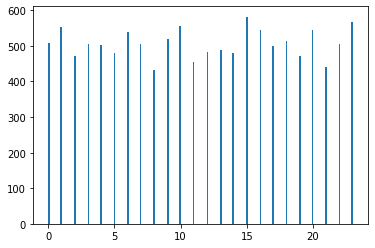

In [12]:
# identifying reversal transactions
reversed_transactions = data[data['transactionType'] == 'REVERSAL']
print(
    'The total dollar amount for reversed transactions is: {}.'.format(sum(reversed_transactions['transactionAmount'])))

dt_idx = [[[x[3] for x in duplicated_transactions[d][c]] for c in duplicated_transactions[d]] for d in
          duplicated_transactions]
dt_idx = sum(sum(dt_idx, []), [])
dt_df = data.iloc[dt_idx]

plt.hist(dt_df['transactionDateTime'].apply(lambda x: x.hour), bins=200)
plt.show()
# for reversed transactions, the total dollar amount is about 2821792 dollars
# Duplicated transactions usually happened within 600 seconds and the amount is usually small. It is also somehow easy
# to get confused with ADDRESS_VERIFICATION transaction type, which always transacts 0.0 dollars to verify the card
# holder. Reversed transactions are varying in time, could happened either in multiple days after the purchase or
# right after the purchase.

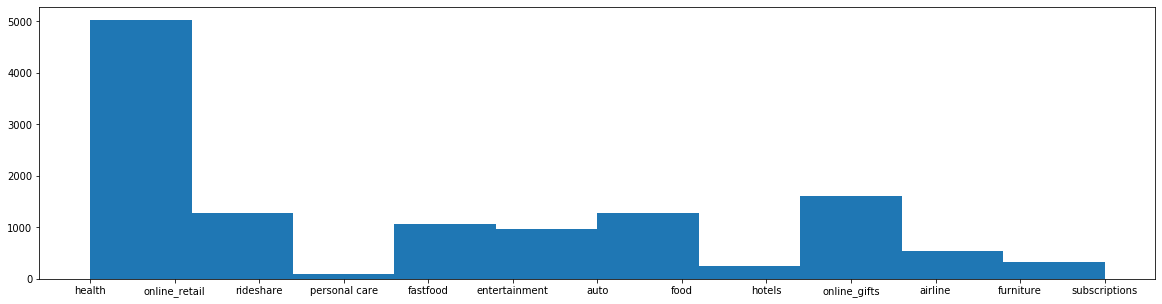

In [13]:
plt.figure(figsize=(20, 5))
plt.hist(data[data['isFraud'] == 1]['merchantCategoryCode'])
plt.show()


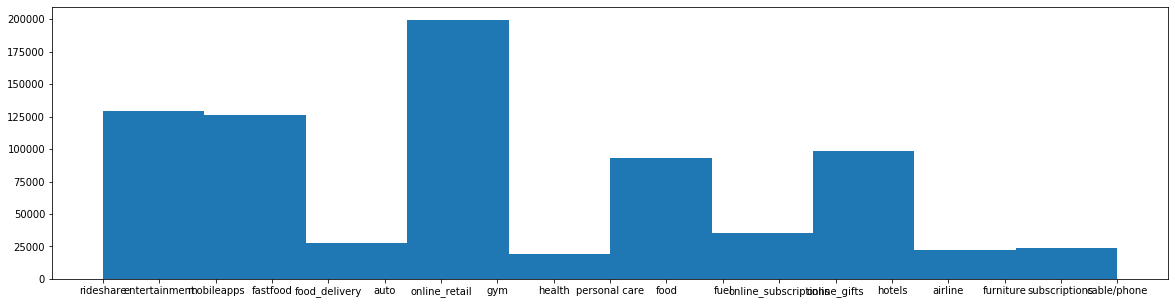

In [14]:
plt.figure(figsize=(20, 5))
plt.hist(data[data['isFraud'] == 0]['merchantCategoryCode'])
plt.show()

# The transaction type may be a good way to distinguish credit fraudulent.
